In [1]:
import time
import pandas as pd
import numpy as np

# 时间戳转字符串
def timestamp_datetime(value):
    format = '%Y-%m-%d %H:%M:%S'
    value = time.localtime(value)
    dt = time.strftime(format, value)
    return dt

### 提取特征

In [2]:
numeric_feats = ['item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_age_level',
                 'user_star_level', 'shop_review_num_level',
                 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description',
                 'hour', 'day',
                 'user_query_day', 'user_query_day_hour',
                 'item_CTR', 'shop_CTR', 
                 ]

nominal_feats = ['item_id', 'user_id', 'shop_id', 'item_brand_id',
                 'item_city_id', 'user_gender_id', 'user_occupation_id', 'context_page_id']

features = numeric_feats + nominal_feats

target = 'is_trade'

def extract_date(data):
    data['time'] = data.context_timestamp.apply(timestamp_datetime)
    data['day'] = data.time.apply(lambda x: int(x[8:10]))
    data['hour'] = data.time.apply(lambda x: int(x[11:13]))
    del data['time']
    return data

def extract_ctr(data, feature, alias):
    '''统计给定数据的转化率
    
    '''
    query_cnt = data.groupby([feature]).size().reset_index().rename(columns={0: 'query_cnt'})
    conversion_cnt = data[data['is_trade'] == 1].groupby([feature]).size().reset_index().rename(columns={0: 'conversion_cnt'})
    ctr = pd.merge(query_cnt, conversion_cnt, how='left', on=[feature])
    ctr[['conversion_cnt']] = ctr[['conversion_cnt']].fillna(0)
    ctr[alias] = ctr['conversion_cnt'] / ctr['query_cnt']
    del ctr['query_cnt']
    del ctr['conversion_cnt']
    return ctr

def extract_history_ctr(data, feature, alias):
    '''统计每一天之前的历史转化率
    
    '''
    history_ctr = pd.DataFrame(columns = [feature, alias, 'day'])
    
    for day in range(18, 26):
        # 每一天之前的历史数据
        history_data = data[data['day'] < day]
        ctr = extract_ctr(history_data, feature, alias)        
    
        # 添加date字段，方便merge
        ctr['day'] = day
        history_ctr = history_ctr.append(ctr)
        
    return history_ctr
    

def extract_manual_features(data):
    
    user_query_day = data.groupby(['user_id', 'day']).size().reset_index().rename(columns={0: 'user_query_day'})
    data = pd.merge(data, user_query_day, how='left',on=['user_id', 'day'])

    user_query_day_hour = data.groupby(['user_id', 'day', 'hour']).size().reset_index().rename(columns={0: 'user_query_day_hour'})
    data = pd.merge(data, user_query_day_hour, how='left',on=['user_id', 'day', 'hour'])
    
    
    item_query_day = data.groupby(['item_id', 'day']).size().reset_index().rename(columns={0: 'item_query_day'})
    data = pd.merge(data, item_query_day, 'left', on=['item_id', 'day'])
    
    item_query_day_hour = data.groupby(['item_id', 'day', 'hour']).size().reset_index().rename(columns={0: 'item_query_day_hour'})
    data = pd.merge(data, item_query_day_hour, 'left',on=['item_id', 'day', 'hour'])
    
    shop_query_day = data.groupby(['shop_id', 'day']).size().reset_index().rename(columns={0: 'shop_query_day'})
    data = pd.merge(data, shop_query_day, 'left', on=['shop_id', 'day'])
    
    shop_query_day_hour = data.groupby(['shop_id', 'day', 'hour']).size().reset_index().rename(columns={0: 'shop_query_day_hour'})
    data = pd.merge(data, shop_query_day_hour, 'left',on=['shop_id', 'day', 'hour'])
       
    history_item_ctr = extract_history_ctr(data, 'item_id', 'item_CTR')
    data = pd.merge(data, history_item_ctr, how='left', on=['item_id', 'day'])
    data[['item_CTR']] = data[['item_CTR']].fillna(-1)
        
    history_shop_ctr = extract_history_ctr(data, 'shop_id', 'shop_CTR')
    data = pd.merge(data, history_shop_ctr, how='left', on=['shop_id', 'day'])
    data[['shop_CTR']] = data[['shop_CTR']].fillna(-1)
    
    history_shop_ctr = extract_history_ctr(data, 'user_id', 'user_CTR')
    data = pd.merge(data, history_shop_ctr, how='left', on=['user_id', 'day'])
    data[['user_CTR']] = data[['user_CTR']].fillna(-1)
    
    feature_with_CTR = ['shop_id', 'item_id', 'day', 'user_id']
    data[feature_with_CTR] = data[feature_with_CTR].astype(np.int64)
    
#     data = pd.get_dummies(data, dummy_na=True, columns=['user_gender_id', 'user_occupation_id', 'context_page_id'])

    
#     data = data.replace(to_replace=[-1], value=np.NaN)
#     data[numeric_feats] = data[numeric_feats].fillna(data.mean())
#     data[numeric_feats] = data[numeric_feats].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

    return data

### 读取训练样本并转换

In [3]:
df_train = pd.read_csv("../round1_ijcai_18_train_20180301.txt", sep=' ')
df_test = pd.read_csv("../round1_ijcai_18_test_a_20180301.txt", sep=' ')

df_train.drop_duplicates(inplace=True)
df_train = extract_date(df_train)
df_test = extract_date(df_test)

num_train = df_train.shape[0]
all_data = pd.concat([df_train, df_test])
all_data = extract_manual_features(all_data)
df_train = all_data[:num_train]
df_test = all_data[num_train:]
del df_test['is_trade']


# 根据日期，取24号为验证集
train_data = df_train.loc[df_train.day < df_train['day'].max()]
val_data = df_train.loc[df_train.day == df_train['day'].max()]

train_data.shape, val_data.shape

((420693, 38), (57418, 38))

In [4]:
train_data.shape,val_data.shape,df_test.shape

((420693, 38), (57418, 38), (18371, 37))

In [ ]:
extract_ctr(df_train, feature='user_gender_id', alias='page_CTR')

In [5]:
features = ['item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'item_city_id','item_brand_id',
                 'user_age_level', 'user_star_level', 'user_gender_id', 'user_occupation_id',
                 'shop_review_num_level','shop_review_positive_rate', 'shop_star_level', 'shop_score_service',
                 'shop_score_delivery', 'shop_score_description','context_page_id',
                 'item_id', 'user_id', 'shop_id', 
                 'day','hour',
                 'user_query_day',
                 'user_query_day_hour',
                 'item_query_day',
                 'item_query_day_hour',
                 'shop_query_day',
                 'shop_query_day_hour',
                 'item_CTR', 
                 'shop_CTR', 
                 'user_CTR'
                 ]

nominal_feats = ['user_gender_id',]



target = 'is_trade'

train_data.columns

Index(['context_id', 'context_page_id', 'context_timestamp', 'day', 'hour',
       'instance_id', 'is_trade', 'item_brand_id', 'item_category_list',
       'item_city_id', 'item_collected_level', 'item_id', 'item_price_level',
       'item_property_list', 'item_pv_level', 'item_sales_level',
       'predict_category_property', 'shop_id', 'shop_review_num_level',
       'shop_review_positive_rate', 'shop_score_delivery',
       'shop_score_description', 'shop_score_service', 'shop_star_level',
       'user_age_level', 'user_gender_id', 'user_id', 'user_occupation_id',
       'user_star_level', 'user_query_day', 'user_query_day_hour',
       'item_query_day', 'item_query_day_hour', 'shop_query_day',
       'shop_query_day_hour', 'item_CTR', 'shop_CTR', 'user_CTR'],
      dtype='object')

### lightgbm

In [6]:
import lightgbm as lgb
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, log_loss
clf = lgb.LGBMClassifier(max_depth=4, n_estimators=100, n_jobs=-1)

clf.fit(train_data[features], train_data[target], feature_name=features, categorical_feature=nominal_feats)

loss_train = log_loss(train_data[target], clf.predict_proba(train_data[features]))
loss_val = log_loss(val_data[target], clf.predict_proba(val_data[features]))

loss_train, loss_val

D:\Program Files (x86)\Anaconda3\lib\site-packages\lightgbm\basic.py:1038: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['user_gender_id']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


(0.08789133538398484, 0.08136917187073993)

### 训练和测试

In [ ]:
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty="l2", solver='liblinear',
                        max_iter=1000, verbose=1)

from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier(n_estimators=100, max_features='auto')

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=5, bootstrap=True, max_features='auto')

clf = gbdt
clf.fit(train_data[features], train_data[target])

loss_train = log_loss(train_data[target], clf.predict_proba(train_data[features]))
predicted = clf.predict_proba(val_data[features])
loss_val = log_loss(val_data[target], predicted)

loss_train, loss_val

# 提交测试数据

In [7]:
sample_weight = val_data.shape[0] / df_test.shape[0]
sample_weight

3.1254694899569975

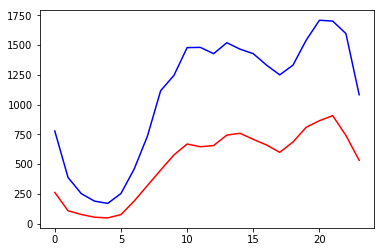

2.435503308517988

In [9]:
aaa=[]
bbb=[]
from matplotlib import pyplot as plt
for hour in range(0,24):
    a = val_data[val_data['hour'] == hour]
    aaa.append(int(len(a.groupby(['item_id']).size())))
    

    b = df_test[df_test['hour'] == hour]
    bbb.append(int(len(b.groupby(['item_id']).size())))
    
    
plt.plot(aaa, color='b', label='25')
plt.plot(bbb, color='r', label='24')
plt.show()

aaa = np.array(aaa)
bbb = np.array(bbb)

c_item = np.mean(aaa / bbb)
c_item

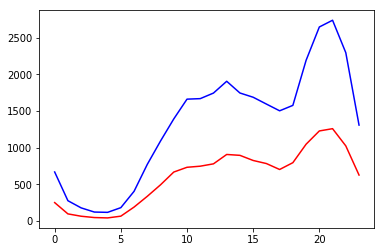

2.295552367573261

In [10]:
aaa=[]
bbb=[]
from matplotlib import pyplot as plt
for hour in range(0,24):
    a = val_data[val_data['hour'] == hour]
    aaa.append(int(len(a.groupby(['user_id']).size())))
    

    b = df_test[df_test['hour'] == hour]
    bbb.append(int(len(b.groupby(['user_id']).size())))
    
    
plt.plot(aaa, color='b', label='25')
plt.plot(bbb, color='r', label='24')
plt.show()
aaa = np.array(aaa)
bbb = np.array(bbb)
c_user = np.mean(aaa / bbb)
c_user

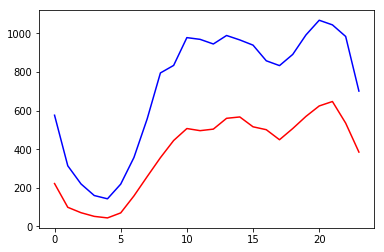

2.1643334402556764

In [11]:
aaa=[]
bbb=[]
from matplotlib import pyplot as plt
for hour in range(0,24):
    a = val_data[val_data['hour'] == hour]
    aaa.append(int(len(a.groupby(['shop_id']).size())))
    

    b = df_test[df_test['hour'] == hour]
    bbb.append(int(len(b.groupby(['shop_id']).size())))
    
    
plt.plot(aaa, color='b', label='25')
plt.plot(bbb, color='r', label='24')
plt.show()

aaa = np.array(aaa)
bbb = np.array(bbb)
c_shop = np.mean(aaa / bbb)
c_shop

In [12]:
feats_user = ['user_query_day', 'user_query_day_hour']
feats_item = ['item_query_day', 'item_query_day_hour']      
feats_shop = ['shop_query_day', 'shop_query_day_hour']           

df_test[feats_user] = df_test[feats_user] * sample_weight / c_user
df_test[feats_item] = df_test[feats_item] * sample_weight / c_item
df_test[feats_shop] = df_test[feats_shop] * sample_weight / c_shop

D:\Program Files (x86)\Anaconda3\lib\site-packages\pandas\core\frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [ ]:
df_train.head

In [13]:

clf = lgb.LGBMClassifier(max_depth=4, n_estimators=100, n_jobs=-1)
clf.fit(df_train[features], df_train[target], feature_name=features, categorical_feature=['user_gender_id'])

loss_train = log_loss(df_train[target], clf.predict_proba(df_train[features]))

df_test['predicted_score'] = clf.predict_proba(df_test[features])[:, 1]

df_test[['instance_id', 'predicted_score']].to_csv(
    '20180326.txt', index=False, sep=' ')

loss_train

D:\Program Files (x86)\Anaconda3\lib\site-packages\lightgbm\basic.py:1038: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['user_gender_id']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
D:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


0.08709125322281835